# Fitting SANS data

Previously, some small angle neutron scattering (SANS) data has been [simulated](./../3-mcstas/SANS_from_function.ipynb) and [reduced](./../4-scipp/sans-reduction.ipynb), and can now be analysed with `easyscience`. 
Before the analysis can begin, it is necessary to load the experimental data and check that it looks reasonable. 
The data can be loaded with `np.loadtxt` as the data has been stored in a simple space-separated column file. 

In [1]:
import numpy as np

q, i, di = np.loadtxt('../4-reduction/sans_iofq_3pulses.dat', unpack=True)

With the data read in, we can produce a quick plot. 

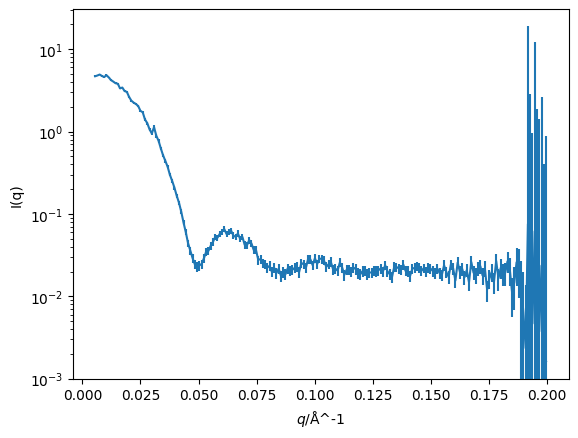

In [3]:
import matplotlib.pyplot as plt

plt.errorbar(q, i, di)
plt.yscale('log')
plt.xlabel('$q$/Å^-1')
plt.ylabel('I(q)')
plt.show()

We now want to consider the mathematical model to be used in the analysis. 
There are SANS models a range of different systems, see for instance [the models in SasView](https://www.sasview.org/docs/user/qtgui/Perspectives/Fitting/models/index.html). 
However, initially, we will assume that our data has arisen from a spherical system. 

The mathematical model for a sphere is 

$$
I(q) = \frac{\text{scale}}{V} \bigg(\frac{3 V \Delta \rho [\sin{(qr)} - qr \cos{(qr)}]}{(qr)^3}\bigg)^2 + \text{bkg}, 
$$ (sphere)

where $\text{scale}$ is a scale factor, $V$ is the volume of the sphere, $\Delta \rho$ is the difference between the solvent and particle scattering length density, $r$ is the radius of the sphere, $\text{bkg}$ is a uniform background, and $q$ is the *q*-vector that the intensity is being calculated for. 

```{admonition} Task
:class: important
The mathematical model described in Eqn. {eq}`sphere` has five parameters. 
What simple mathematical simplification can be performed to reduce this to four?  
```

```{admonition} Click to show solution
:class: dropdown
The volume of a sphere is related to the radius of the sphere as 

$$
V = \frac{4}{3} \pi r^3. 
$$ (volume-sphere)

Therefore, the parameter $V$ can be replaced with Eqn. {eq}`volume-sphere`.
```

```{admonition} Task
:class: important
Four parameters is a suitable number for modelling. 
Therefore, we should write a function that implements your reduced dimensionality version of Eqn. {eq}`sphere`. 
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [4]:
def sphere(q):
    """
    The function for the form factor of a sphere. 
    
    Parameters
    ----------
    q: 
        q-vectors to calculate for.
    
    Returns
    -------
    : 
        The modelled intensity.
    """
    qr = q * r.value
    V = 4 / 3 * np.pi * r.value ** 3
    return scale.value / V * (3 * V * delta_rho.value * (np.sin(qr) - qr * np.cos(qr)) / ((qr) ** 3)) ** 2 + bkg.value

```{admonition} Task
:class: important
Create four `Parameter` objects, for $\text{scale}$, $\Delta \rho$, $r$, and $\text{bkg}$. 
Each should have an initial value and a uniform prior distribution based on the values given in {numref}`sans-parameters`, except for the $\text{scale}$ which should be fixed to a value of 1.4 &times; 10<sup>-8</sup>.
```

```{list-table} Parameter values for the spherical model.
:name: sans-parameters
:header-rows: 1
:align: center

* - Parameter
  - Initial Value
  - Min
  - Max
* - $\text{scale}$
  - 1.4 &times; 10<sup>-8</sup>
  - N/A
  - N/A
* - $\Delta \rho$
  - 3
  - 0
  - 10
* - $r$
  - 80
  - 10
  - 1000
* - $\text{bkg}$
  - 3.0 &times; 10<sup>-3</sup>
  - 1.0 &times; 10<sup>-3</sup>
  - 1.0 &times; 10<sup>-2</sup>
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [5]:
from easyscience.Objects.new_variable import Parameter

scale = Parameter(name='scale', value=1.4e-7, fixed=True)
delta_rho = Parameter(name='delta_rho', value=3, fixed=False, min=0, max=10)
r = Parameter(name='r', value=80, fixed=False, min=0, max=1000)
bkg = Parameter(name='bkg', value=0.01, fixed=False, min=0.001, max=0.1)

It is now possible to compare our model at the initial estimates to the simulated data. 

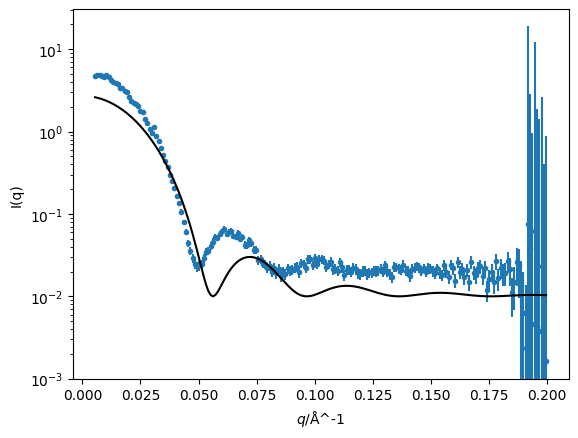

In [7]:
plt.errorbar(q, i, di, marker='.', ls='', color='C0')
plt.plot(q, sphere(q), 'k', zorder=10)
plt.yscale('log')
plt.xlabel('$q$/Å^-1')
plt.ylabel('I(q)')
plt.show()

```{admonition} Task
:class: important
Using `easyscience`, obtain maximum likelihood estimates for the four parameters of the model from comparison with the data.
```

<i class="fa-solid fa-bell"></i> **Click below to show code solution**

In [8]:
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter

params = BaseObj(name='params', delta_rho=delta_rho, r=r, bkg=bkg)
f = Fitter(params, sphere)

res = f.fit(x=q, y=i, weights=1/di)

We can then plot the model and the data together as before and print the values of the parameters along with their uncertainties. 

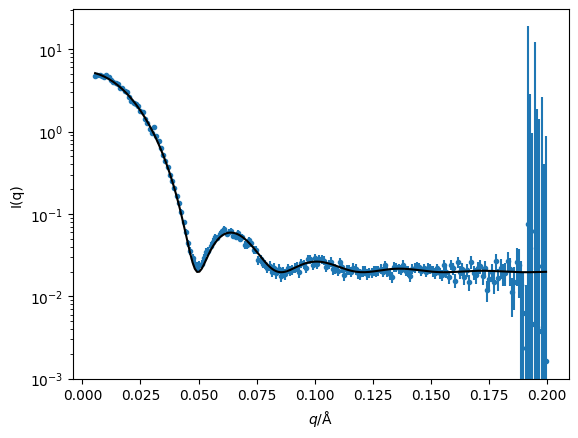

In [9]:
plt.errorbar(q, i, di, marker='.', ls='', color='C0')
plt.plot(q, sphere(q), 'k-', zorder=10)
plt.yscale('log')
plt.xlabel('$q$/Å')
plt.ylabel('I(q)')
plt.show()

In [10]:
delta_rho, r, bkg

(<Parameter 'delta_rho': 3.5241 ± 0.0089, bounds=[0.0:10.0]>,
 <Parameter 'r': 90.2746 ± 0.1503, bounds=[0.0:1000.0]>,
 <Parameter 'bkg': 0.0196 ± 0.0003, bounds=[0.001:0.1]>)